# Finding Cycles in NFT Transactions

## Overview

A Non-fungible Token (NFT) is a digital asset which cannot be copied, substituted, or subdivided, meaning it is wholly unique.

![title](http://web.archive.org/web/20220328080727im_/https://blog.portion.io/content/images/2021/07/Kevin-McCoy-Quantum.gif)

NFT’s are stored on blockchain systems, notably Ethereum, with the owner of an NFT being whomever has access to the wallet it is stored within.

Since the first NFT, Quantum (shown above), many new NFT artworks have arisen including Cryptokitties and Cryptopunks. This culminated in a boom in 2021 which included the arrival of the Bored Ape Yacht Club, with NFTS reaching a global market valued of $15.7 Billion.

In this example we will analyse an NFT dataset in order to find suspicious trading cycles.

1. Using Raphtory to load the NFT data as a graph
2. Execute a cycle detection algorithm
3. Analyse the results to find suspicious cycles of NFTs

The data we used is a cleaned and trimmed version from [1]


[1] Nadini, M., Alessandretti, L., Di Giacinto, F. et al. Mapping the NFT revolution: market trends, trade networks, and visual features. Sci Rep 11, 20902 (2021). https://doi.org/10.1038/s41598-021-00053-8

## Loading data with Raphtory

First we install some extra packages

In [ ]:
pip install scipy seaborn

Now we import the following so we can use Raphtory

In [1]:
import time
from calendar import timegm
from pyraphtory.context import PyRaphtory
from pyraphtory.builder import *
from pyraphtory.spouts import FileSpout
from pyraphtory.sinks import FileSink
from pyraphtory.formats import JsonFormat
import csv
from nft_helper import *

Below are our data sources
- `date_price` a dictionary containing the daily ETH-USD price, we we need to convert as some prices are missing
- `filename` - this is the cleaned transaction data, which represents NFTs being bought by wallets 
- `at_time` - is the time we want to run our analysis, this is the last time in the dataset 

In [ ]:
# Download the data

!wget https://osf.io/download/mw3vh/ -O ETH-USD.csv
!wget https://osf.io/download/kaumt/ -O Data_API_reduced.csv 

In [5]:
eth_price_csv = 'ETH-USD.csv'
filename = "Data_API_reduced.csv"
at_time = 1561661534

date_price = setup_date_prices(eth_price_csv)

For this example, we are going to create a bipartite graph. 

In our graph, we have wallets on the left, and NFTs on the right. 

Each edge represents that an NFT was purchased by a wallet. 

The `parse_graph` function will take each line, from the spout, and turn these into graph updates. 


![title](https://www.raphtory.com/images/nfts/buy_nft.png)


In [6]:
def parse_graph(graph, line):
    file_line = line.split(',')
    if file_line[0] == "Smart_contract":
        return
    # Seller details
    seller_address = file_line[3]
    seller_address_hash = graph.assign_id(seller_address)
    # Buyer details
    buyer_address = file_line[5]
    buyer_address_hash = graph.assign_id(buyer_address)
    # Transaction details
    datetime_str = file_line[13]
    timestamp_utc = time.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")
    timestamp = timegm(timestamp_utc)
    tx_hash = file_line[2]
    token_id_str = file_line[1]
    token_id_hash = graph.assign_id(token_id_str)

    crypto = file_line[8]
    if crypto != 'ETH':
        return

    if file_line[9] == "":
        price_usd = date_price[datetime_str[0:10]]
    else:
        price_usd = float(file_line[9])

    # NFT Details
    collection_cleaned = file_line[14]
    market = file_line[11]
    category = file_line[15]

    #  add buyer node
    graph.add_vertex(
        timestamp,
        buyer_address_hash,
        Properties(ImmutableProperty("address", buyer_address)),
        Type("Wallet")
    )

    # Add node for NFT
    graph.add_vertex(
        timestamp,
        token_id_hash,
        Properties(
            ImmutableProperty("id", token_id_str),
            ImmutableProperty("collection", collection_cleaned),
            ImmutableProperty("category", category)
        ),
        Type("NFT")
    )

    # Creating a bipartite graph,
    # add edge between buyer and nft
    graph.add_edge(
        timestamp,
        buyer_address_hash,
        token_id_hash,
        Properties(
            StringProperty("transaction_hash", tx_hash),
            StringProperty("crypto", crypto),
            StringProperty("price_usd", str(price_usd)),
            StringProperty("market", market),
            StringProperty("token_id", token_id_str),
            StringProperty("buyer_address", buyer_address)
        ),
        Type("Purchase")
    )

Now we will start a raphtory instance and load our data

In [7]:
pr = PyRaphtory(logging=True).open()
graph = pr.new_graph()

graph.load(Source(FileSpout(filename), GraphBuilder(parse_graph)))

10:40:43.597 [io-compute-blocker-5] INFO  com.raphtory.internals.management.Py4JServer - Starting PythonGatewayServer...
Port: 60003
Secret: d740fe48110b3a213522d89a0f90c616f8dbfda785a03a6827b553dd2cb8b461
10:40:44.496 [Thread-12] INFO  com.raphtory.internals.management.PythonInterop$ - Shutting down pyraphtory
10:40:44.570 [Thread-11] INFO  com.raphtory.internals.context.LocalContext$ - Creating Service for 'empty_fuchsia_wildcat'
10:40:44.603 [io-compute-blocker-3] INFO  com.raphtory.internals.management.Prometheus$ - Prometheus started on port /0:0:0:0:0:0:0:0:9999
10:40:45.198 [io-compute-blocker-3] INFO  com.raphtory.internals.components.partition.PartitionOrchestrator$ - Creating '1' Partition Managers for 'empty_fuchsia_wildcat'.
10:40:45.476 [io-compute-blocker-5] INFO  com.raphtory.internals.components.partition.PartitionManager - Partition 0: Starting partition manager for 'empty_fuchsia_wildcat'.


RuntimeError: No overloaded implementations matched for apply with args=('/Users/haaroony/Documents/nft/Data_API_reduced.csv',) and kwargs={}

## Executing a Cycle detection algorithm

Below is a visual representation of the cycle detection. 

This is when a NFT has been sold by a wallet, but eventually ends up being owned by it again. This can involve a chain of any number of other wallets, take any amount of time, and increase or decrease the price by any amount.

Below we can see an example of such a cycle where Wallet A sold an NFT to Wallet B for $50$ on Monday, but its back in their position by Thursday, costing them $750$. They either have serious sellers remorse or, more likely, the same person owns all these wallets and is trying to pump up the price of the given NFT.

Our algorithm:
- Gets each NFT
- For each time it was purchased, checks the list of purchases to see if a user re-bought the NFT at a later date, at a higher price

This all happens within the `step` function. A `step` is executed once on each node.  

The code has been optimised to O(n) complexity. 

![title](https://www.raphtory.com/images/nfts/NFT_Cycle.png)

In [ ]:
from pyraphtory.algorithm import PyAlgorithm
from pyraphtory.graph import TemporalGraph, Row
from pyraphtory.vertex import Vertex

CYCLES_FOUND: str = "CYCLES_FOUND"

class CycleMania(PyAlgorithm):
def __call__(self, graph: TemporalGraph) -> TemporalGraph:
    def step(v: Vertex):
        if v.type() != "NFT":
            v[CYCLES_FOUND] = []
            return
        all_cycles = []
        all_purchases = sorted(v.explode_in_edges(), key=lambda e: e.timestamp())
        purchasers = list(map(lambda e:
                              dict(price_usd=float(e.get_property_or_else("price_usd", 0.0)),
                                   nft_id=e.get_property_or_else("token_id", "_UNKNOWN_"),
                                   tx_hash=e.get_property_or_else("transaction_hash", ""),
                                   time=e.timestamp(),
                                   buyer=e.get_property_or_else("buyer_address", "_UNKNOWN_")),
                                  all_purchases))
                              all_purchases))
        if len(purchasers) > 2:
            buyers_seen = {}
            for pos, item_sale in enumerate(purchasers):
                buyer_id = item_sale['buyer']
                if buyer_id not in buyers_seen:
                    buyers_seen[buyer_id] = pos
                else:
                    prev_pos = buyers_seen[buyer_id]
                    prev_price = purchasers[prev_pos]['price_usd']
                    current_price = item_sale['price_usd']
                    buyers_seen[buyer_id] = pos
                    if prev_price < current_price:
                        all_cycles.append(purchasers[prev_pos:pos + 1])
        if len(all_cycles):
            v[CYCLES_FOUND] = all_cycles
        else:
            v[CYCLES_FOUND] = []

    return graph.reduced_view().step(step)

def tabularise(self, graph: TemporalGraph):
    def get_cycles(v: Vertex):
        vertex_type = v.type()
        rows_found = [Row()]
        if vertex_type == "NFT" and len(v[CYCLES_FOUND]):
            nft_id = v.get_property_or_else('collection', '_UNKNOWN_')
            cycles_found = v[CYCLES_FOUND]
            nft_collection = v.get_property_or_else('collection', '_UNKNOWN_')
            nft_category = v.get_property_or_else('category', '_UNKNOWN_')
            rows_found = list(map(lambda single_cycle:
                                  Row(
                                      nft_id,
                                      nft_collection,
                                      nft_category,
                                      len(single_cycle),
                                      dict(cycle={'sales': single_cycle}),
                                      profit_usd=float(single_cycle[len(single_cycle) - 1]['price_usd']) -
                                                 float(single_cycle[0]['price_usd']),
                                      buyer=str(single_cycle[0]['buyer'])
                                  ), cycles_found))
        return rows_found

    return graph.explode_select(lambda v: get_cycles(v)).filter(lambda row: len(row.get_values()) > 0)

We run the algorithm as follows 

In [ ]:
graph
    .at(at_time)
    .past()
    .execute(CycleMania())
    .write_to(FileSink('/tmp/raphtory_nft_python', format=JsonFormat()))
    .wait_for_job()

## Analysing the results

First we import the tools we are using for analysis

In [9]:
import pandas as pd
import json
import seaborn as sns
from scipy import stats
import numpy as np
import time
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '16'
from nft_helper import *
from collections import Counter

### Read data

We will now read the data that Raphtory produced. 

Please check which path the data was saved too, and adjust the line below. 

In our case, Raphtory saved the data to the `CycleMania_8220652547042296969` folder. 

In [14]:
# data = load_json('/tmp/raphtory_nft_python/CycleMania_8220652547042296969/partition-0.json')
data = load_json("/private/tmp/raphtory_nft_scala/CycleMania_7751601672828082098/partition-0.json")
new_data = []
# filter any cycles that are less than 2 hops
for d in data:
    if d['row'][3] > 2:
        new_data.append(d)
data = new_data
data_df = pd.DataFrame(data)

amount of data 11848


In [15]:
data_df["profit"]=data_df["row"].apply(lambda x: x[4]['profit_usd'])
data_df["min_ts"] = data_df["row"].apply(lambda x: min(map(lambda y: y["time"],x[4]['cycle']['sales'])))
data_df["max_ts"] = data_df["row"].apply(lambda x: max(map(lambda y: y["time"],x[4]['cycle']['sales'])))
data_df["length"] = data_df["row"].apply(lambda x: len(x[4]['cycle']['sales']))
data_df["duration_days"] = (data_df["max_ts"] - data_df["min_ts"])/86400
display(data_df)

,timestamp,window,row,profit,min_ts,max_ts,length,duration_days
0,1561661534,None,"[34508_Etheremon, Etheremon, Games, 132, {'buy...",14.948830,1559431032,1561568522,132,24.739468
1,1561661534,None,"[34508_Etheremon, Etheremon, Games, 35, {'buye...",11.719305,1561069915,1561554482,35,5.608414
2,1561661534,None,"[34508_Etheremon, Etheremon, Games, 24, {'buye...",5.783180,1561212460,1561540043,24,3.791470
3,1561661534,None,"[34508_Etheremon, Etheremon, Games, 8, {'buyer...",3.094390,1561426005,1561525986,8,1.157188
4,1561661534,None,"[34508_Etheremon, Etheremon, Games, 9, {'buyer...",4.967755,1561397526,1561511567,9,1.319919
...,...,...,...,...,...,...,...,...
11698,1561661534,None,"[1043670_Cryptokittie, Cryptokittie, Art, 3, {...",0.137700,1550255282,1550312298,3,0.659907
11699,1561661534,None,"[1043670_Cryptokittie, Cryptokittie, Art, 12, ...",0.042525,1550013179,1550226823,12,2.472731
11700,1561661534,None,"[1043670_Cryptokittie, Cryptokittie, Art, 4, {...",0.230175,1549984672,1550027402,4,0.494560
11701,1561661534,None,"[1043670_Cryptokittie, Cryptokittie, Art, 6, {...",2.278800,1549557084,1549998801,6,5.112465


## Cycle length distributions

Below is a simple CDF showing the distribution of the lengths of cycles. 

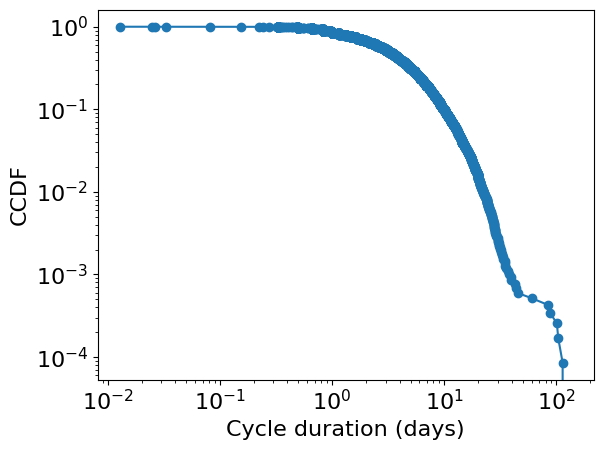

In [27]:
x,y = ccdf(data_df.duration_days)

fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(x,y, marker="o")
ax.set_ylabel("CCDF")
ax.set_xlabel("Cycle duration (days)")

plt.show()

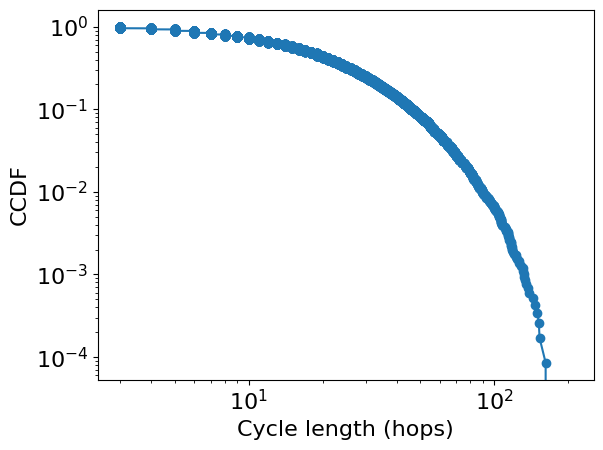

In [28]:
x,y = ccdf(data_df.length)

fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(x,y, marker="o")
ax.set_ylabel("CCDF")
ax.set_xlabel("Cycle length (hops)")

plt.show()

## How many traders took part in cycles?

In [29]:
traders_profit = {}
for row in data:
    trade = {
        'profit_usd': row['row'][4]['profit_usd'],
        'buyer':  row['row'][4]['buyer'],
        'cycle_size': row['row'][3],
        'nft_id': row['row'][0],
        'cycle': row['row'][4]['cycle']['sales']
    }
    trader = trade['buyer']
    profit = trade['profit_usd']
    if trader not in traders_profit:
        traders_profit[trader] = []
    traders_profit[trader].append(profit)
traders_avg = {}
for trader, _profit in traders_profit.items():
    avg = sum(_profit)/len(_profit)
    traders_avg[trader] = {
        'avg': avg, 
        'count': len(_profit),
        'total_profit': sum(_profit)
    }
    
traders_count_sorted = sorted(traders_avg, key=lambda x: traders_avg[x]['count'], reverse=True)

for t in traders_count_sorted[:50]:
    print(t)
    print(traders_avg[t])
    print()

0x8acc1421ec98689461ff5777de8ad6648dc6d643
{'avg': 2.25195539174045, 'count': 617, 'total_profit': 1389.4564767038576}

0x00c9da65b33b4f7034b5f50b90f5f6d8320d6ab8
{'avg': 2.1960905438311666, 'count': 616, 'total_profit': 1352.7917749999988}

0xa21e0974137bf8400eb7dca606d9dcb190d79ed9
{'avg': 2.30064266286645, 'count': 614, 'total_profit': 1412.5945950000003}

0x838c14eb3eabe4cb6a696d286c7b2a466629d0ee
{'avg': 2.357247238562093, 'count': 612, 'total_profit': 1442.6353100000008}

0x1c1ef71445010114f41ac1feb32dbf5d7281e90f
{'avg': 2.347460337171053, 'count': 608, 'total_profit': 1427.2558850000003}

0x6a47b60c377450a460d3eb828d534ee66eead668
{'avg': 2.29687113410596, 'count': 604, 'total_profit': 1387.3101649999999}

0xe738725cdcc41c91f734dd7b5b9659df994d6dda
{'avg': 2.2413728476821198, 'count': 604, 'total_profit': 1353.7892000000004}

0x463215edb66fb6a8f0c979e739a731977617699f
{'avg': 2.1705960117056864, 'count': 598, 'total_profit': 1298.0164150000005}

0x1e7f320cf5a938465d501f6bd6c405

Above, we can see that 20 traders participated in over 528 cycles each. 

Lets write some code to inspect these NFT cycles in more depth. 

The `pretty_cycle` function takes a cycle and prints out each subsequent trade and the profit and time between trades.  

In [30]:
def pretty_cycle(cycle):
    as_string = '   '
    prev_price = cycle[0]['price_usd']
    prev_time = cycle[0]['time']
    for item in cycle:
        diff = item['price_usd']-prev_price
        time_secs = item['time']-prev_time
        time_mins = time_secs/60
        time_hours = time_secs/60/60
        time_days = time_secs/60/60/24 
        prev_time = item['time']
        time_str = '%.1fm/%.1fh/%.2fd' % (time_mins, time_hours, time_days)
        as_string += 'T(d) '+time_str+', B: '+item['buyer'][:4]+'.. $'+str(item['price_usd'])+'('+str(diff)+') '+item['tx_hash']+'\n->'
    as_string = as_string[:-3]
    print(as_string)

# Lets take a look at the trader who did the most cycles

In [36]:
largest_trader_addr = traders_count_sorted[0] # '0x8acc1421ec98689461ff5777de8ad6648dc6d643'
largest = []
for trade in data:
    # ignore any rari tokens, as they are fractionalised
    #. ignore any short trades 
    if '_Rari' in trade['row'][0] or trade['row'][3] <= 2:
        continue
    if trade['row'][4]['buyer'] == largest_trader_addr:
        largest.append(trade)

#### Which NFTs did they trade?

In [33]:
from collections import Counter
most_common_nft_collection = []
most_common_nft = []
for trade in largest:
    nft_collection =  trade['row'][0].split('_')
    if len(nft_collection) > 2:
        print("crap")
    most_common_nft.append(trade['row'][0])
    most_common_nft_collection.append(nft_collection[1])
most_common_nft_collection = set(most_common_nft_collection)
most_common_nft_collection = Counter(most_common_nft_collection)
most_common_nft = Counter(most_common_nft)
most_common_nft_collection

Counter({'Mlbchampion': 1, 'Cryptokittie': 1, 'Etheremon': 1})

#### What happens when we look at their cycles in more detail?

In [35]:
pretty_cycle(largest[10]['row'][4]['cycle']['sales'])

   T(d) 0.0m/0.0h/0.00d, B: 0x8a.. $27.154920000000004(0.0) 0xcf9c78d0d6298cfacf16b1333c29c3e925ff27f80c6835062e3167b92e8cbd78
->T(d) 235.0m/3.9h/0.16d, B: 0xf5.. $27.154920000000004(0.0) 0x1e662233d7f3d7986054062c0a538955ed66c6e52d29f1ba2b8e4c961138255b
->T(d) 240.7m/4.0h/0.17d, B: 0x87.. $27.154920000000004(0.0) 0xa0a72d30beb89211cfbce243df96b81b070d563213ad201aa644d1db99529ad4
->T(d) 234.1m/3.9h/0.16d, B: 0x6a.. $27.154920000000004(0.0) 0x25bd70c90e9c1cb169326bb6479ebd3bc438ef1a58d8d6a822ff7d81cd85e0cb
->T(d) 239.7m/4.0h/0.17d, B: 0xa2.. $27.43884000000001(0.2839200000000055) 0xc4ecc72367add3b226833699cb22ef94f78a56eb630c2606816d34dc439e878a
->T(d) 236.8m/3.9h/0.16d, B: 0xcd.. $27.43884000000001(0.2839200000000055) 0x4b51c6b9377c8778adf60ca5f99ed9ee4d5cd41145f2d2c8e238a61043a89cc2
->T(d) 238.2m/4.0h/0.17d, B: 0xba.. $27.43884000000001(0.2839200000000055) 0x1ac4cc0424eba8113ea068e8c9eff3f9d8c07352ba43e9cd1683e52d5900a89d
->T(d) 238.8m/4.0h/0.17d, B: 0x87.. $27.43884000000001(0.283920

We have found something here, this trader trades each nft between wallets within a ~4 hour window??

#### What was the time between each transaction?

In [37]:
import math
def time_finder(cycle):
    prev_time = cycle[0]['time']
    times = []
    for sale in cycle:
        time_secs = sale['time']-prev_time
        time_hours = time_secs/60/60
        prev_time = sale['time']
        time_hours = round(time_hours, 1)
        times.append(time_hours)
    return times

time_found = []
for trade in largest:
    time_found.extend(time_finder(trade['row'][4]['cycle']['sales']))
time_found = Counter(time_found)
print("total times : %i" % sum(time_found.values()))
between_39_41 = time_found[3.4]+time_found[3.5]+time_found[3.6] +time_found[3.7] +time_found[3.8] +time_found[3.9] +time_found[4.0] +time_found[4.1] +time_found[4.2]+time_found[4.3]+time_found[4.4]+time_found[4.5]+time_found[4.6]
print("times between 3.4 and 4.6 : %i - %.2fp" % (between_39_41, between_39_41/sum(time_found.values())*100))

total times : 13193
times between 3.4 and 4.6 : 11658 - 88.37p


#### Who did they trade with?

In [34]:
wallet_interactions = []
for trade in largest:
    for sale in trade['row'][4]['cycle']['sales']:
        wallet_interactions.append(sale['buyer'])
wallet_interactions = Counter(wallet_interactions)
sorted(wallet_interactions.items(), key=lambda x: x[1], reverse=True), len(wallet_interactions)

([('0x8acc1421ec98689461ff5777de8ad6648dc6d643', 1234),
  ('0xa21e0974137bf8400eb7dca606d9dcb190d79ed9', 710),
  ('0x179d698f5a1c84c3ff4c5eb04e553c15a0c1d8d8', 674),
  ('0xe738725cdcc41c91f734dd7b5b9659df994d6dda', 662),
  ('0x1c1ef71445010114f41ac1feb32dbf5d7281e90f', 659),
  ('0x838c14eb3eabe4cb6a696d286c7b2a466629d0ee', 653),
  ('0xf5aee6d7b838d5ede8aa65d31dbc11116545180c', 649),
  ('0x6a47b60c377450a460d3eb828d534ee66eead668', 649),
  ('0xbabda06088c242fb2a763aa7cc99706cb77ba735', 644),
  ('0x00c9da65b33b4f7034b5f50b90f5f6d8320d6ab8', 635),
  ('0x463215edb66fb6a8f0c979e739a731977617699f', 624),
  ('0x1e7f320cf5a938465d501f6bd6c405feb3a70f6c', 623),
  ('0xa37e6b46fa8e1a6f1ddbf035c4e0230b8414ff04', 618),
  ('0x87b77fabfeb869150b8e1b9462603f9a639c5fae', 612),
  ('0x6e13c7e25c2cda6f5c8c4e431bee480bfb312c28', 600),
  ('0x236ef21dc36d0aec3990dd5ee84a9d5320644262', 596),
  ('0xadd12bd6375dc21d579cc4abcfa04864d6ac9a62', 594),
  ('0x7316e9cf94bef40d4981d66a5c41c38b6b32454c', 590),
  ('0x68d

Interestingly they only traded their NFTs with 20 other wallets. 

In [49]:
fellow_traders = list(wallet_interactions.keys())
for t in fellow_traders:
    print(t)
    print(traders_avg[t])
    print()

0x8acc1421ec98689461ff5777de8ad6648dc6d643
{'avg': 2.25195539174045, 'count': 617, 'total_profit': 1389.4564767038576}

0x87b77fabfeb869150b8e1b9462603f9a639c5fae
{'avg': 2.285133267419961, 'count': 531, 'total_profit': 1213.4057649999993}

0x1e7f320cf5a938465d501f6bd6c405feb3a70f6c
{'avg': 2.226550720268008, 'count': 597, 'total_profit': 1329.2507800000008}

0xbabda06088c242fb2a763aa7cc99706cb77ba735
{'avg': 2.312860959860383, 'count': 573, 'total_profit': 1325.2693299999994}

0x7316e9cf94bef40d4981d66a5c41c38b6b32454c
{'avg': 2.2200820802919687, 'count': 548, 'total_profit': 1216.604979999999}

0xa37e6b46fa8e1a6f1ddbf035c4e0230b8414ff04
{'avg': 2.1527055114638456, 'count': 567, 'total_profit': 1220.5840250000003}

0xcdcadf0279ee021a0c40a31ac10fa69e028e21d0
{'avg': 2.3056730797101417, 'count': 552, 'total_profit': 1272.7315399999982}

0xf5aee6d7b838d5ede8aa65d31dbc11116545180c
{'avg': 2.2790570608695653, 'count': 575, 'total_profit': 1310.45781}

0x463215edb66fb6a8f0c979e739a731977617

All of these traders also participated in many cycles. 

#### What were the patterns of the fellow traders cycles?

In [50]:
import random

fellow_traders
print(len(fellow_traders))

others_sibs = {}
for sibling in fellow_traders:
    others_sibs[sibling] = []
    for trade in data:
        if '_Rari' in trade['row'][0] or trade['row'][3] <= 2:
            continue
        if trade['row'][4]['buyer'] == sibling:
            others_sibs[sibling].append(trade)
    print(sibling)
    rand = random.choice(range(0,len(others_sibs[sibling])))
    pretty_cycle(others_sibs[sibling][rand]['row'][4]['cycle']['sales'])
    print()

20
0x8acc1421ec98689461ff5777de8ad6648dc6d643
   T(d) 0.0m/0.0h/0.00d, B: 0x8a.. $29.63283000000001(0.0) 0x3f209008d2bf5d53680402fa2b6f93ec22c00b53d84be4f058694fe0ee700d3c
->T(d) 234.9m/3.9h/0.16d, B: 0x68.. $29.63283000000001(0.0) 0x9e29fefc5fc9fa14df9a0af35ba38066acda45c9a7b2169ddb28f012e7375ac0
->T(d) 240.5m/4.0h/0.17d, B: 0x1e.. $29.63283000000001(0.0) 0x15cf93df67c77c61092d12aeb7ff13d21636cd53a5810dfb50f4706d89b89d9b
->T(d) 234.9m/3.9h/0.16d, B: 0xe7.. $29.63283000000001(0.0) 0xae58b5e29a233af96edf11ef7ea8b3e039e0aa35399f9e4ac2a90f02d772ae4b
->T(d) 239.8m/4.0h/0.17d, B: 0x73.. $29.63283000000001(0.0) 0xf5fb4ebfff84d332aa2836b76cba3f81bb6d1e5ffca16b6e1bc42a52b3c0eced
->T(d) 234.7m/3.9h/0.16d, B: 0xad.. $29.63283000000001(0.0) 0x4133ba3614b0e888b5d130d28861d2d7094b00c2ac40f60ef28367532da9ce4f
->T(d) 240.9m/4.0h/0.17d, B: 0xba.. $32.203065(2.570234999999993) 0x5cc138f67427369b9a6e2bfb35ead5762198cef5adeb9f80964d89df32b32a7b
->T(d) 236.5m/3.9h/0.16d, B: 0x83.. $32.203065(2.57023499999

All of these traders also follow the same, or a similar pattern.

Trading with each other, waiting ~4 hours before trading again. 